# **Analyze behavioral data from Auditory VR experiment**

We really need to immediately convert the raw data files to a better database form. Until we figure out a good process to do that, this notebook begins by extracting the data into a better form.


# Get info about virtual machine

In [1]:
# Disk information
!df -h
# CPU information
!lscpu | grep "MHz"
# If using a GPU
!nvidia-smi -L
!nvcc --version
# Memory information
!cat /proc/meminfo | grep 'MemAvailable'

Filesystem      Size  Used Avail Use% Mounted on
udev            7.7G     0  7.7G   0% /dev
tmpfs           1.6G  4.1M  1.6G   1% /run
/dev/nvme0n1p3  930G  438G  445G  50% /
tmpfs           7.7G   30M  7.7G   1% /dev/shm
tmpfs           5.0M  4.0K  5.0M   1% /run/lock
tmpfs           7.7G     0  7.7G   0% /sys/fs/cgroup
/dev/loop2      144M  144M     0 100% /snap/code/52
/dev/loop4       56M   56M     0 100% /snap/core18/1944
/dev/loop3      136M  136M     0 100% /snap/chromium/1466
/dev/loop5      163M  163M     0 100% /snap/gnome-3-28-1804/145
/dev/loop0      136M  136M     0 100% /snap/chromium/1461
/dev/loop6       98M   98M     0 100% /snap/core/10583
/dev/loop7       98M   98M     0 100% /snap/core/10577
/dev/loop8      218M  218M     0 100% /snap/gnome-3-34-1804/60
/dev/loop9      219M  219M     0 100% /snap/gnome-3-34-1804/66
/dev/loop10      65M   65M     0 100% /snap/gtk-common-themes/1513
/dev/loop11      56M   56M     0 100% /snap/core18/1932
/dev/loop12      65M   65M    

# Access Data
We'll use Google Drive (where there's unlimited storage) as our mechanism for uploading data to the Colaboratory. The benefit of this is that no keys have to be stored. But you do have to make sure to click the link and copy in the key that is generated into the cell.

Alternative - use Dropbox API!


In [19]:
if False:
  from google.colab import drive
  drive.mount('/content/gdrive')
  
  source_root = '/content/gdrive/MyDrive/Seahorse-Sibo'
  useLocal = False

  !ls /content/gdrive/MyDrive/Seahorse-Sibo/BehavioralData/
elif False:
  # Install Dropbox
  !pip install dropbox
  import dropbox

  access_token = 'sl.AqpFT6rZt46zaievqojdeYgkOieR1HUkU6SXacHcoxCeC41NyGcwIzniuoIVHltzhl-UhkacHVvD3kPG1Ii7IWsdn2BW1s5HeDP8TXkEuWoaHZL_Bb5l8fJlLOm0l7a1XG4Smh4' # Get your access token from https://www.dropbox.com/developers/apps
  useLocal = False
  
  dbx = dropbox.Dropbox(access_token)
  print('Connected to Dropbox')

else:
  useLocal = True
  source_root = '/home/ckemere/Dropbox/SiboData'


# Data Loading Functions

Eventually, we'll put these in a library. As we still need to add some functionality, we'll just put them here for now.

In [27]:
import sys, os, glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import yaml
import re

import scipy.ndimage
import scipy.stats

def dec_to_bin_array(d, bits=None, bit_order='<'):
    # No need for axis argument: just put newaxis on end,
    # and can transpose later if needed
    
    # Convert to numpy array if needed
    if not isinstance(d, np.ndarray):
        d = np.array([d])
    
    # Calculate minimum bits to represent integer
    min_bits = np.max(np.ceil(np.log2(np.maximum(d, np.ones(d.shape))))).astype(np.int64)
    if bits is None:
        bits = min_bits
    elif bits < min_bits:
        raise ValueError('Not enough bits to represent number. At least %d bits required.' % min_bits)
    
    # Broadcast binary representation to new axis at end
    b = np.zeros(list(d.shape) + [bits], dtype=np.int16)
    rem = d
    bit = bits
    while (bit > 0) and (rem > 0).any():
        bit -= 1
        b[..., bit] = (rem >= 2**bit)
        rem = rem % 2**bit
    
    # Return binary representation
    if bit_order == '<':
        return b
    elif bit_order == '>':
        return b[..., ::-1]
    else:
        raise ValueError('Unknown bit order \'%s\'' % bit_order)

def find_experiment_dirs(root_dir):
    exp_dirs = glob.glob(os.path.join(root_dir, 'ExperimentLog*'))
    regex = re.compile('.*ExperimentLog(?P<date>\d*-\d*-\d*)_(?P<time>\d*)_(?P<cohort>..)(?P<animal>..)_(?P<subsession>.*)')
    parsed_dir_names = [regex.match(d).groupdict() for d in exp_dirs]
    exp_dirs_df = pd.DataFrame(parsed_dir_names, index=exp_dirs)
    exp_dirs_df['session_time'] = pd.to_datetime(exp_dirs_df['date'] +' '+ exp_dirs_df['time']) 

    return exp_dirs_df

def extract_wheel_data(f, encoder_gain):
    # open file:
    data = pd.read_csv(f +"/DataLog.csv", sep=",", header=None, skiprows=[0,1])
    data.columns = ["Mastertime", "GPIO", "Encoder", "UnwrappedEncoder", "last_ts"]
    # unpack into np.arrays

    d = 20.2 # cm

    # extract wheel data, motor data, and lick data
    if data['Mastertime'][0] == 0: # New format file where we stored the first Encoder value
        start = 1
        UnwrappedEncoder = np.array(data['UnwrappedEncoder'])
        linear_pos = (UnwrappedEncoder[1:] - data['UnwrappedEncoder'][0]) * d /encoder_gain * np.pi
        rawtime = data['Mastertime'][1:]
    else: # Old style
        start = 0
        UnwrappedEncoder = np.array(data['UnwrappedEncoder'])
        linear_pos = (UnwrappedEncoder - UnwrappedEncoder[0]) * d /encoder_gain * np.pi
        rawtime = data['Mastertime']
    
    rawtime = rawtime.to_numpy()
    wheeltime = (rawtime - rawtime[0])/1000
#     wheeltime_linux = last_ts - last_ts[0]

    #last_ts = np.array(data['last_ts'][start:])
    last_ts = data['last_ts'][start:].to_numpy()

    ## get motor and lick
    gpio_array = dec_to_bin_array(np.array(data['GPIO'][start:]), bits = 16)
    motor_idx = np.array(np.where(np.diff(gpio_array[:,4]) ==1)[0]) +1  # 5th bit for reward

    lick_idx = np.array(np.where(np.diff(gpio_array[:,2]) ==1)[0]) +1  # 3th bit for lick
    
    if os.path.exists(os.path.join(f, 'RewardzoneLog.csv')):
        rf = os.path.join(f, 'RewardzoneLog.csv')
        rdata = pd.read_csv(rf, sep=",", header=None, 
                                names=['Type','TS','Pos','GPIO','IsClassical','Licked'], 
                                skiprows=[0,1], error_bad_lines=False)
        reward_data = []
        for i, r in rdata.iterrows():
            if r.Type == 'Reward':
                continue
            assert(r.Type == 'Entered')
            if ((i+1) < len(rdata)) and (rdata.iloc[i+1].Type == 'Reward'):
                reward_data.append([r.TS, r.Pos, r.IsClassical, 
                    rdata.iloc[i+1].TS, rdata.iloc[i+1].Pos, rdata.iloc[i+1].Licked])
            else:
                reward_data.append([r.TS, r.Pos, r.IsClassical, np.nan, np.nan, False])
        reward_data = np.vstack(reward_data)
    else:
        reward_data = None
        
    return linear_pos, wheeltime, lick_idx, motor_idx, start, reward_data
#     return linear_pos, wheeltime, wheeltime_linux, lick_idx, motor_idx, gpio_array, UnwrappedEncoder, rawtime


def find_lap_boundaries(pos, track_length, offset=0):
    number_of_laps = int(np.ceil(np.max(pos) / track_length))
    lap_starts = np.arange(number_of_laps, step=1) * track_length + offset
    lap_start_idx = np.zeros(number_of_laps, dtype=np.int32)
    
    for i, s in enumerate(lap_starts):
        if i > 1:
            start_idx = lap_start_idx[i-1]
        else:
            start_idx = 0
        lap_start_idx[i] = np.argmax(pos[start_idx:] - s >= 0) + start_idx    
    
    return lap_start_idx

def find_events_by_lap(lap_start_idx, events):
    events_by_lap = np.empty(lap_start_idx.shape[0])
    events_by_lap[:] = np.nan
    laps_with_events = np.digitize(events, lap_start_idx) - 1
    events_by_lap[laps_with_events] = events
    
    return events_by_lap[:-1] # Through away last event because the lap is (presumably) incomplete


def find_events_by_lap_boundaries(pos, events, start, stop, track_length):
    number_of_laps = int(np.ceil(np.max(pos) / track_length))
    events_by_laps = []
    
    bounds_by_lap = np.arange(number_of_laps-1, step=1) * track_length + np.expand_dims(np.array([start, stop]),1)
    bounds_by_lap = bounds_by_lap.T
    
    event_pos = pos[events]
    sidx = 0
    for i, b in enumerate(bounds_by_lap):
        lap_events = np.argwhere((event_pos[sidx:] > b[0]) & (event_pos[sidx:] <= b[1]))
        if len(lap_events) > 0:
            events_by_laps.append(events[lap_events + sidx])
        else:
            events_by_laps.append([])
        sidx = sidx + len(lap_events)
    
    return events_by_laps


def get_session_config(exp_dir, reward_length=15):
    # YAML parameters: task settings
    with open(os.path.join(exp_dir +"/ParsedConfig.yaml"), 'r') as f:
        Config = yaml.safe_load(f)

    # I think we want to throw errors for these not being present
    track_length = Config['Maze']['Length'] #cm
    if 'EncoderGain' in Config['Maze']:
        encoder_gain = Config['Maze']['EncoderGain']

    zonedistance = Config['AuditoryStimuli']['Defaults']['Modulation']['Width'] #cm
    reward_zone_start = Config['RewardZones']['RewardZoneList']['Reward1']['RewardZoneStart']
    reward_type = Config['RewardZones']['RewardZoneList']['Reward1']['Type']
    
    if track_length != zonedistance*8:
        raise(ValueError('Track length is not 8 times zone distance'))

    is_multilap = False
    for stimname, stim in Config['AuditoryStimuli']['StimuliList'].items():
      if (stim['Type'] == 'MultilapBackground'):
        is_multilap = True

    # Calculate zones used for analysis. 
    # We use a standard "reward_length" to facilitate comparison across days. In reality, the reward
    # zone start and end are configured in the YAML file. 
    # TODO: Check for differences from default value (15)
    aud_stim = Config['AuditoryStimuli']['StimuliList']
    A_start = aud_stim['Zone_A']['CenterPosition'] - aud_stim['Zone_A']['Modulation']['Width']/2
    B1_start = aud_stim['Zone_B1']['CenterPosition'] - aud_stim['Zone_B1']['Modulation']['Width']/2
    C_start = aud_stim['Zone_C']['CenterPosition'] - aud_stim['Zone_C']['Modulation']['Width']/2
    B2_start = aud_stim['Zone_B2']['CenterPosition'] - aud_stim['Zone_B2']['Modulation']['Width']/2

    reward_zone_end = reward_zone_start + reward_length

    ZonesByName = {'A': [A_start, A_start + reward_length],
                'AnticipatoryB1': [B1_start-reward_length, B1_start], 
                'B1': [B1_start, B1_start + reward_length],
                'C1': [C_start, C_start + reward_length],
                'AnticipatoryB2': [B2_start-reward_length, B2_start], 
                'B2': [B2_start, B2_start + reward_length]}

    if not is_multilap:
      background_level = Config['AuditoryStimuli']['StimuliList']['BackgroundSound']['BaselineGain']
    else:
      background_level = None

    
    return track_length, encoder_gain, zonedistance, reward_zone_start, reward_zone_end, reward_type, is_multilap, \
           ZonesByName, background_level


def analyze_licks(reward_data, lick_idx, linear_pos_wrap, reward_idx_by_lap):
  if reward_data is None:
    reward_pos_by_lap = np.array([linear_pos_wrap[int(i)] if not np.isnan(i) else np.nan for i in reward_idx_by_lap])

    # Create a list that describes each lap in terms of whether a lick immediately preceeded
    #   reward. This will help us assess whether each lap was classical or operant
    licked_before_by_lap = [len(np.argwhere(lick_idx+1 == m))==1 
                            if not np.isnan(m) else np.nan for m in reward_idx_by_lap]
    licked_before_by_lap = np.array(licked_before_by_lap)
    is_classical = None

    # summary data
    operant_misses = np.sum(np.isnan(licked_before_by_lap)) # (True)
    operant_hits =  np.nansum(licked_before_by_lap) # (NaN)
    if (operant_hits + operant_misses == 0):
        operant_hit_rate = 0
    else:
        operant_hit_rate = operant_hits / (operant_hits + operant_misses)
    try:
        assert(np.isnan(operant_hit_rate) == False)
    except:
        print(operant_misses)
        print(operant_hits)
        assert(False)
    classical = np.sum(licked_before_by_lap == 0)

    version = 0

  else:
    reward_pos_by_lap = reward_data[:,4] # get this data from RewardzoneLog.csv
    licked_before_by_lap = reward_data[:,5]
    is_classical = reward_data[:,2]

    # summary data
    if (np.mean(is_classical==0) == 0): # 100% classical (no operant)
        operant_misses = 0
        operant_hits = 0
        operant_hit_rate = 0
    else: 
      operant_misses = np.sum((licked_before_by_lap == 0) & (is_classical == 0)) # (True)
      operant_hits =  np.sum((licked_before_by_lap == 1) & (is_classical == 0)) # (NaN)
      
      # Check for data errors when calculating hit rate
      if (operant_hits + operant_misses == 0):          
            print(is_classical)
            print(np.mean(is_classical==0))
            assert(False)
      else:
          operant_hit_rate = operant_hits / (operant_hits + operant_misses)
      
      try:
          assert(np.isnan(operant_hit_rate) == False)
      except:
          print(operant_misses)
          print(operant_hits)
          assert(False)

    classical = np.sum(is_classical == 1)

    version = 1


  return version, reward_pos_by_lap, licked_before_by_lap, is_classical, \
         classical, operant_hit_rate, operant_hits, operant_misses


In [31]:
def extract_session_data(exp_dirs_df, binsize=1, 
    reward_space_window=[-15,30], reward_time_window = [-1, 2]):

    # binsize = 1 # 5 cm bins for spatial histograms
    # reward_space_window - window for defining histograms around reward

    ######for all sessions (except pre or adjusting sessions)---main program----#####
    lick_pattern_data = {}
    FS = 500

    for d, df_data in exp_dirs_df.iterrows():
        lick_pattern_data[d] = {}

        ### ONLY want to extract meta data and plot for "real" sessions (don't want "pre" or "adjusting" session.) other ways to do it?
        if re.match('.*(?:pre|adj).*', df_data['subsession']): 
            print('Skipping: ', d)
            continue

        track_length, encoder_gain, zonedistance, reward_zone_start, reward_zone_end, reward_type, \
          is_multilap, ZonesByName, background_level = \
              get_session_config(d)
        
        if is_multilap:
          print('{} is a multilap. Skipping for now.'.format(d))
          continue


        fname = os.path.join(d, 'DataLog.csv')
        print(fname)
        linear_pos, wheeltime, lick_idx, motor_idx, style, reward_data = extract_wheel_data(d, encoder_gain)
        linear_pos_wrap = linear_pos % track_length
    
        lap_start_idx = find_lap_boundaries(linear_pos, track_length)
        if len(lap_start_idx) < 2:
            print('Fewer than 2 laps. Continuing!')
            continue
        
        reward_idx_by_lap = find_events_by_lap(lap_start_idx, motor_idx)

        if reward_type == 'Classical':
          if (len(motor_idx) < len(reward_idx_by_lap)):
              print('Something happened - fewer rewards {} than laps {}'
                  ' on a Classical Day.'.format(len(motor_idx), len(reward_idx_by_lap)))
              continue
        
        version, reward_pos_by_lap, licked_before_by_lap, is_classical, \
         classical, operant_hit_rate, operant_hits, operant_misses = \
           analyze_licks(reward_data, lick_idx, linear_pos_wrap, reward_idx_by_lap)

        
        # Define consumatory licks as those within the reward sound zone 
        potential_consump_licks = find_events_by_lap_boundaries(linear_pos, lick_idx, 
                                                                reward_zone_start, reward_zone_start+30, track_length)
        first_consumatory_lick_idx = np.empty(reward_idx_by_lap.shape[0])
        first_consumatory_lick_idx[:] = np.nan
        first_consumatory_lick_pos = first_consumatory_lick_idx.copy()
        for i, reward_idx in enumerate(reward_idx_by_lap):
            if ~np.isnan(reward_idx):
                if len(potential_consump_licks[i]) > 0:
                    if np.max(potential_consump_licks[i]) > reward_idx:
                        idx = np.argmax(np.array(potential_consump_licks[i]) > reward_idx)
                        first_consumatory_lick_idx[i] = potential_consump_licks[i][idx]
                        first_consumatory_lick_pos[i] = linear_pos_wrap[potential_consump_licks[i][idx]]

        first_lick_latency = first_consumatory_lick_idx - reward_idx_by_lap
        
        
        LicksByZone = {}
        for zname, zone in ZonesByName.items():
            LicksByZone[zname] = {}
            LicksByZone[zname]['Bounds'] = zone
            lbz = find_events_by_lap_boundaries(linear_pos, lick_idx, zone[0], zone[1], track_length)
            num_licks = np.array([len(ev) for ev in lbz])
            LicksByZone[zname]['NumLicks'] = num_licks
            first_lick = np.hstack([ev[0] if len(ev) > 0 else np.nan for ev in lbz])
            first_lick_pos = np.hstack([linear_pos_wrap[ev[0]] if len(ev) > 0 else np.nan for ev in lbz])
            LicksByZone[zname]['FirstLickPos'] = first_lick_pos

        false_alarms = LicksByZone['B2']['NumLicks']
        first_false_alarm_position = LicksByZone['B2']['FirstLickPos']

        # Want two sets of space histograms with a row per lap.
        # (1) aligned on lap position
        # (2) aligned on reward time
        #   - occupancy
        #   - speed (isn't this just 1/occupancy sort of???)
        #   - licks
        #   - reward location
        # Can also make a smoothed time histogram aligned on reward (what does that mean)

        velocity = np.gradient(scipy.ndimage.gaussian_filter1d(linear_pos, sigma=10))
        
        spatial_bins = np.arange(0, track_length+binsize, binsize)
        occupancy_histogram = np.zeros((len(lap_start_idx)-1, spatial_bins.shape[0] - 1))
        speed_histogram = np.zeros((len(lap_start_idx)-1, spatial_bins.shape[0] - 1))
        lick_histogram = np.zeros((len(lap_start_idx)-1, spatial_bins.shape[0] - 1))

        reward_spatial_bins = np.arange(reward_space_window[0], reward_space_window[1], binsize)
        occupancy_histogram_reward = np.zeros((len(lap_start_idx)-1, reward_spatial_bins.shape[0] - 1))
        speed_histogram_reward = np.zeros((len(lap_start_idx)-1, reward_spatial_bins.shape[0] - 1))
        lick_histogram_reward = np.zeros((len(lap_start_idx)-1, reward_spatial_bins.shape[0] - 1))
        
        for i, lst in enumerate(lap_start_idx[:-1]):
            lend= lap_start_idx[i+1]
            occupancy_histogram[i,:], _ = np.histogram(linear_pos_wrap[lst:lend], spatial_bins)
            speed_histogram[i,:], _, _ = scipy.stats.binned_statistic(linear_pos_wrap[lst:lend], velocity[lst:lend], 
                                                                    'mean', spatial_bins)
            lap_licks = linear_pos_wrap[lick_idx[(lick_idx >= lst) & (lick_idx < lend)]]
            if len(lap_licks) > 0:
                lick_histogram[i,:], _, _ = scipy.stats.binned_statistic(lap_licks, np.ones(lap_licks.shape), 
                                                                    'count', spatial_bins)
            if np.isnan(reward_idx_by_lap[i]):
                occupancy_histogram_reward[i,:] = np.nan
                speed_histogram_reward[i,:] = np.nan
                lick_histogram_reward[i,:] = np.nan
                continue
            
            rwd_idx = int(reward_idx_by_lap[i])
            rwd_pos = reward_pos_by_lap[i]
            rwd_st = np.argmax(linear_pos_wrap[lst:rwd_idx] > rwd_pos + reward_space_window[0]) + lst
            rwd_end = np.argmax(linear_pos_wrap[rwd_idx:lend] > rwd_pos + reward_space_window[1]) + rwd_idx
            occupancy_histogram_reward[i,:], _ = np.histogram(linear_pos_wrap[rwd_st:rwd_end], 
                                                            reward_spatial_bins+rwd_pos)
            speed_histogram_reward[i,:], _, _ = scipy.stats.binned_statistic(linear_pos_wrap[rwd_st:rwd_end], 
                                                                    velocity[rwd_st:rwd_end], 
                                                                    'mean', reward_spatial_bins+rwd_pos)
            
            reward_lap_licks = linear_pos_wrap[lick_idx[(lick_idx >= rwd_st) & (lick_idx < rwd_end)]]
            if len(reward_lap_licks) > 0:
                lick_histogram_reward[i,:], _, _ = scipy.stats.binned_statistic(
                    reward_lap_licks, np.ones(reward_lap_licks.shape), 
                    'count', reward_spatial_bins+reward_zone_start)

        
        lick_pattern_data[d] = {'TrackLength': track_length,
                                'RewardType': reward_type,
                                'Version': version,
                                'BackgroundLevel': background_level,
                                'RewardPosition': reward_pos_by_lap, 
                                'LickedBefore': licked_before_by_lap,
                                'IsClassical': is_classical,
                                'RewardZone': reward_zone_start,
                                'LicksByZone': LicksByZone,
                                'FirstConsumpLickLatency': first_consumatory_lick_idx - reward_idx_by_lap,
                                'FirstConsumpLickPos': first_consumatory_lick_pos,
                                'FirstFalseAlarmLickPos': first_false_alarm_position,
                                'OccupancyHist': occupancy_histogram,
                                'SpeedHist': speed_histogram,
                                'LickHist': lick_histogram,
                                'OccupancyHistRwd': occupancy_histogram_reward,
                                'SpeedHistRwd': speed_histogram_reward,
                                'LickHistRwd': lick_histogram_reward,
                                'OperantLaps': operant_hits + operant_misses,
                                'OperantHitLaps': operant_hits,
                                'OperantMissLaps': operant_misses,
                                'ClassicalLaps': classical,
                                'TotalLaps': len(licked_before_by_lap),
                                 # Summary data

                                'OperantHitRate': operant_hit_rate,
                                'ClassicalHitRate': np.mean(first_consumatory_lick_pos[licked_before_by_lap[:len(first_consumatory_lick_pos)]==0] < reward_zone_end),
                                'FalseAlarmRate': np.mean(false_alarms > 0),
                                'MedianFALickPos': np.nanmedian(first_false_alarm_position),
                                # 'MedianLickLatency': np.nanmean(first_lick_latency), # What zone is this???
                                # 'MedianLickPos': np.nanmean(first_consumatory_lick_pos), # What zone is this??
                                'MedianLickLatency_Operant': np.nanmean(first_lick_latency[licked_before_by_lap[:len(first_lick_latency)] == 1]),
                                'MedianLickPos_Operant': np.nanmean(first_consumatory_lick_pos[licked_before_by_lap[:len(first_lick_pos)] ==1]),
                                'MedianLickLatency_Classical': np.nanmean(first_lick_latency[licked_before_by_lap[:len(first_lick_latency)] == 0]),
                                'MedianLickPos_Classical': np.nanmean(first_consumatory_lick_pos[licked_before_by_lap[:len(first_consumatory_lick_pos)] == 0])
                                                            }    
    
    lick_pattern_df = pd.DataFrame.from_dict(lick_pattern_data, orient='index')
    return lick_pattern_df


# Analysis Start

In [22]:
import matplotlib
# Use real fonts, not outlines

matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

import matplotlib.pyplot as plt

import seaborn as sns
import pandas as pd
import numpy as np
import scipy.ndimage

In [23]:
import os
root_dirs = os.path.join(source_root, 'BehavioralData/*') # The files from the different computers are in subdirectories here. 

In [24]:
use_cache = False
if os.path.exists('CachedDataFrame.hdf5') and use_cache:
    cached_data_available = True
    print('Reading from cache')
    df = pd.read_hdf('CachedDataFrame.hdf5','CachedData')
else:
    cached_data_available = False

In [25]:
if not cached_data_available:
    #from V1_B_loading_functions import find_experiment_dirs
    exp_dirs_df = find_experiment_dirs(root_dirs)

In [32]:
if not cached_data_available:
    #from V1_B_loading_functions import extract_session_data
    behavioral_data_fg = extract_session_data(exp_dirs_df) 

/home/ckemere/Dropbox/SiboData/BehavioralData/habenula/ExperimentLog2020-10-23_1428_V1B3_ses4_-20/DataLog.csv
Skipping:  /home/ckemere/Dropbox/SiboData/BehavioralData/habenula/ExperimentLog2020-09-21_1227_V1B2_pre_adjcamfocus
/home/ckemere/Dropbox/SiboData/BehavioralData/habenula/ExperimentLog2021-01-13_1827_V1B1_ses2/DataLog.csv


<ipython-input-31-d26d1803356f>:161: RuntimeWarning: invalid value encountered in less
  'ClassicalHitRate': np.mean(first_consumatory_lick_pos[licked_before_by_lap[:len(first_consumatory_lick_pos)]==0] < reward_zone_end),


/home/ckemere/Dropbox/SiboData/BehavioralData/habenula/ExperimentLog2020-09-15_1645_V1B2_ses2/DataLog.csv


<ipython-input-31-d26d1803356f>:166: RuntimeWarning: Mean of empty slice
  'MedianLickLatency_Operant': np.nanmean(first_lick_latency[licked_before_by_lap[:len(first_lick_latency)] == 1]),
<ipython-input-31-d26d1803356f>:167: RuntimeWarning: Mean of empty slice
  'MedianLickPos_Operant': np.nanmean(first_consumatory_lick_pos[licked_before_by_lap[:len(first_lick_pos)] ==1]),


/home/ckemere/Dropbox/SiboData/BehavioralData/habenula/ExperimentLog2020-10-15_1426_V1B3_ses4_-20/DataLog.csv
/home/ckemere/Dropbox/SiboData/BehavioralData/habenula/ExperimentLog2020-09-24_1301_V1B2_ses1/DataLog.csv
/home/ckemere/Dropbox/SiboData/BehavioralData/habenula/ExperimentLog2020-10-24_1451_V1B3_ses9_-14/DataLog.csv
/home/ckemere/Dropbox/SiboData/BehavioralData/habenula/ExperimentLog2020-10-13_1255_V1B3_ses2_-14/DataLog.csv
/home/ckemere/Dropbox/SiboData/BehavioralData/habenula/ExperimentLog2020-09-14_1740_V1B3_ses2/DataLog.csv
/home/ckemere/Dropbox/SiboData/BehavioralData/habenula/ExperimentLog2020-09-15_1804_V1B1_ses2/DataLog.csv
/home/ckemere/Dropbox/SiboData/BehavioralData/habenula/ExperimentLog2020-10-13_1330_V1B3_ses5_-8/DataLog.csv
Skipping:  /home/ckemere/Dropbox/SiboData/BehavioralData/habenula/ExperimentLog2020-09-09_1507_V1B4_pre
/home/ckemere/Dropbox/SiboData/BehavioralData/habenula/ExperimentLog2021-01-28_1412_V1B2_ses1/DataLog.csv
/home/ckemere/Dropbox/SiboData/Be

<ipython-input-31-d26d1803356f>:168: RuntimeWarning: Mean of empty slice
  'MedianLickLatency_Classical': np.nanmean(first_lick_latency[licked_before_by_lap[:len(first_lick_latency)] == 0]),
<ipython-input-31-d26d1803356f>:169: RuntimeWarning: Mean of empty slice
  'MedianLickPos_Classical': np.nanmean(first_consumatory_lick_pos[licked_before_by_lap[:len(first_consumatory_lick_pos)] == 0])


/home/ckemere/Dropbox/SiboData/BehavioralData/habenula/ExperimentLog2020-10-17_1447_V1B3_ses5_-8/DataLog.csv
/home/ckemere/Dropbox/SiboData/BehavioralData/habenula/ExperimentLog2020-10-16_1502_V1B3_ses10_-20/DataLog.csv
/home/ckemere/Dropbox/SiboData/BehavioralData/habenula/ExperimentLog2020-10-16_1428_V1B3_ses6_-8/DataLog.csv
/home/ckemere/Dropbox/SiboData/BehavioralData/habenula/ExperimentLog2020-09-30_1450_V1B1_ses1_50-10/DataLog.csv
/home/ckemere/Dropbox/SiboData/BehavioralData/habenula/ExperimentLog2020-10-25_1433_V1B3_ses1_-20/DataLog.csv
/home/ckemere/Dropbox/SiboData/BehavioralData/habenula/ExperimentLog2021-01-25_1647_V1B2_ses1/DataLog.csv
Skipping:  /home/ckemere/Dropbox/SiboData/BehavioralData/habenula/ExperimentLog2020-09-17_1731_V1B1_pre
/home/ckemere/Dropbox/SiboData/BehavioralData/habenula/ExperimentLog2020-10-17_1517_V1B3_ses9_-8/DataLog.csv
/home/ckemere/Dropbox/SiboData/BehavioralData/habenula/ExperimentLog2021-01-15_1644_V1B2_ses1/DataLog.csv
/home/ckemere/Dropbox/Si

/home/ckemere/Dropbox/SiboData/BehavioralData/habenula/ExperimentLog2021-01-27_1628_V1B2_ses1/DataLog.csv
/home/ckemere/Dropbox/SiboData/BehavioralData/habenula/ExperimentLog2021-02-02_1641_V1B2_ses2 is a multilap. Skipping for now.
/home/ckemere/Dropbox/SiboData/BehavioralData/habenula/ExperimentLog2021-01-29_1653_V1B2_ses2/DataLog.csv
/home/ckemere/Dropbox/SiboData/BehavioralData/habenula/ExperimentLog2020-10-20_1507_V1B3_ses7_-20/DataLog.csv
/home/ckemere/Dropbox/SiboData/BehavioralData/habenula/ExperimentLog2020-10-22_1525_V1B3_ses9_-14/DataLog.csv
/home/ckemere/Dropbox/SiboData/BehavioralData/habenula/ExperimentLog2020-09-08_1725_V1B4_ses1/DataLog.csv
/home/ckemere/Dropbox/SiboData/BehavioralData/habenula/ExperimentLog2021-01-26_1728_V1B2_ses2/DataLog.csv
/home/ckemere/Dropbox/SiboData/BehavioralData/habenula/ExperimentLog2021-01-26_1547_V1B2_ses1/DataLog.csv
/home/ckemere/Dropbox/SiboData/BehavioralData/habenula/ExperimentLog2020-09-21_1228_V1B2_ses1/DataLog.csv
/home/ckemere/Dro

/home/ckemere/Dropbox/SiboData/BehavioralData/habenula/ExperimentLog2021-01-31_1638_V1B2_ses2 is a multilap. Skipping for now.
/home/ckemere/Dropbox/SiboData/BehavioralData/habenula/ExperimentLog2020-10-19_1527_V1B3_ses5_-8/DataLog.csv
/home/ckemere/Dropbox/SiboData/BehavioralData/habenula/ExperimentLog2020-10-25_1451_V1B3_ses4_-20/DataLog.csv
/home/ckemere/Dropbox/SiboData/BehavioralData/habenula/ExperimentLog2020-10-16_1434_V1B3_ses7_-20/DataLog.csv
/home/ckemere/Dropbox/SiboData/BehavioralData/habenula/ExperimentLog2020-10-20_1430_V1B3_ses2_-8/DataLog.csv
/home/ckemere/Dropbox/SiboData/BehavioralData/habenula/ExperimentLog2020-10-19_1607_V1B3_ses10_20/DataLog.csv
/home/ckemere/Dropbox/SiboData/BehavioralData/habenula/ExperimentLog2020-10-15_1403_V1B3_ses2_-14/DataLog.csv
/home/ckemere/Dropbox/SiboData/BehavioralData/habenula/ExperimentLog2020-10-20_1545_V1B3_ses10_-20/DataLog.csv
/home/ckemere/Dropbox/SiboData/BehavioralData/habenula/ExperimentLog2020-10-17_1438_V1B3_ses3_-8/DataLog

/home/ckemere/Dropbox/SiboData/BehavioralData/lemniscus/ExperimentLog2020-10-20_1555_V1B2_ses8_-14/DataLog.csv
/home/ckemere/Dropbox/SiboData/BehavioralData/lemniscus/ExperimentLog2020-10-22_1536_V1B2_ses4_-20/DataLog.csv
/home/ckemere/Dropbox/SiboData/BehavioralData/lemniscus/ExperimentLog2020-09-20_1329_V1B3_ses1/DataLog.csv
/home/ckemere/Dropbox/SiboData/BehavioralData/lemniscus/ExperimentLog2020-10-17_1631_V1B2_ses7_-20/DataLog.csv
/home/ckemere/Dropbox/SiboData/BehavioralData/lemniscus/ExperimentLog2020-09-21_1502_V1B1_ses2/DataLog.csv
Fewer than 2 laps. Continuing!
/home/ckemere/Dropbox/SiboData/BehavioralData/lemniscus/ExperimentLog2020-10-19_1504_V1B1_ses11_-14/DataLog.csv
/home/ckemere/Dropbox/SiboData/BehavioralData/lemniscus/ExperimentLog2020-10-15_1301_V1B2_ses1_camfrozelap108/DataLog.csv
/home/ckemere/Dropbox/SiboData/BehavioralData/lemniscus/ExperimentLog2020-09-22_1707_V1B3_ses2/DataLog.csv
/home/ckemere/Dropbox/SiboData/BehavioralData/lemniscus/ExperimentLog2020-10-25_1

/home/ckemere/Dropbox/SiboData/BehavioralData/lemniscus/ExperimentLog2020-09-16_1543_V1B3_ses3_camfroze/DataLog.csv
Something happened - fewer rewards 11 than laps 12 on a Classical Day.
/home/ckemere/Dropbox/SiboData/BehavioralData/lemniscus/ExperimentLog2020-10-22_1512_V1B2_ses2_-14/DataLog.csv
/home/ckemere/Dropbox/SiboData/BehavioralData/lemniscus/ExperimentLog2020-10-23_1501_V1B2_ses1_-20/DataLog.csv
/home/ckemere/Dropbox/SiboData/BehavioralData/lemniscus/ExperimentLog2020-09-22_1421_V1B1_ses1/DataLog.csv
/home/ckemere/Dropbox/SiboData/BehavioralData/lemniscus/ExperimentLog2020-10-14_1532_V1B1_discardbadses/DataLog.csv
/home/ckemere/Dropbox/SiboData/BehavioralData/lemniscus/ExperimentLog2020-10-16_1518_V1B2_ses2_-14/DataLog.csv
/home/ckemere/Dropbox/SiboData/BehavioralData/lemniscus/ExperimentLog2020-10-18_1707_V1B2_ses11_-8/DataLog.csv
/home/ckemere/Dropbox/SiboData/BehavioralData/lemniscus/ExperimentLog2020-10-19_1555_V1B2_ses6_-8_frozelap6/DataLog.csv
/home/ckemere/Dropbox/Sibo

Skipping:  /home/ckemere/Dropbox/SiboData/BehavioralData/lemniscus/ExperimentLog2021-01-16_1438_V1B3_pre_nocam
/home/ckemere/Dropbox/SiboData/BehavioralData/lemniscus/ExperimentLog2020-10-15_1549_V1B1_ses2_-8_26laps/DataLog.csv
/home/ckemere/Dropbox/SiboData/BehavioralData/lemniscus/ExperimentLog2020-09-23_1505_V1B3_ses3_240_camfroze/DataLog.csv
/home/ckemere/Dropbox/SiboData/BehavioralData/lemniscus/ExperimentLog2020-10-24_1541_V1B2_ses5_-8/DataLog.csv
/home/ckemere/Dropbox/SiboData/BehavioralData/lemniscus/ExperimentLog2020-10-20_1533_V1B2_ses6_-14/DataLog.csv
/home/ckemere/Dropbox/SiboData/BehavioralData/lemniscus/ExperimentLog2020-10-22_1439_V1B1_ses9_-8/DataLog.csv
/home/ckemere/Dropbox/SiboData/BehavioralData/lemniscus/ExperimentLog2020-09-24_1146_V1B4_ses1/DataLog.csv
/home/ckemere/Dropbox/SiboData/BehavioralData/lemniscus/ExperimentLog2020-10-17_1513_V1B1_ses7_-20/DataLog.csv
/home/ckemere/Dropbox/SiboData/BehavioralData/lemniscus/ExperimentLog2020-10-24_1537_V1B2_ses4_-20/Data

/home/ckemere/Dropbox/SiboData/BehavioralData/lemniscus/ExperimentLog2020-10-24_1325_V1B1_ses1_-20_frozelap13/DataLog.csv
/home/ckemere/Dropbox/SiboData/BehavioralData/lemniscus/ExperimentLog2020-10-17_1401_V1B1_ses1_-20/DataLog.csv
/home/ckemere/Dropbox/SiboData/BehavioralData/lemniscus/ExperimentLog2020-10-13_1638_V1B1_ses9_-14/DataLog.csv
/home/ckemere/Dropbox/SiboData/BehavioralData/lemniscus/ExperimentLog2020-09-23_1720_V1B3_ses4_camfroze/DataLog.csv
/home/ckemere/Dropbox/SiboData/BehavioralData/lemniscus/ExperimentLog2020-09-24_1231_V1B1_ses1_240/DataLog.csv
/home/ckemere/Dropbox/SiboData/BehavioralData/lemniscus/ExperimentLog2020-10-21_1505_V1B1_ses11_-14/DataLog.csv
/home/ckemere/Dropbox/SiboData/BehavioralData/lemniscus/ExperimentLog2020-09-18_1558_V1B3_ses2/DataLog.csv
/home/ckemere/Dropbox/SiboData/BehavioralData/lemniscus/ExperimentLog2020-10-18_1654_V1B2_ses10_-20/DataLog.csv
/home/ckemere/Dropbox/SiboData/BehavioralData/lemniscus/ExperimentLog2021-01-13_1815_V1B3_ses1/Dat

/home/ckemere/Dropbox/SiboData/BehavioralData/lemniscus/ExperimentLog2020-10-19_1452_V1B1_ses9_-14/DataLog.csv
/home/ckemere/Dropbox/SiboData/BehavioralData/lemniscus/ExperimentLog2020-09-30_1643_V1B1_ses2/DataLog.csv
/home/ckemere/Dropbox/SiboData/BehavioralData/lemniscus/ExperimentLog2020-10-22_1419_V1B1_ses6_-14/DataLog.csv
/home/ckemere/Dropbox/SiboData/BehavioralData/lemniscus/ExperimentLog2020-10-16_1541_V1B2_ses4_-20/DataLog.csv
/home/ckemere/Dropbox/SiboData/BehavioralData/lemniscus/ExperimentLog2020-10-18_1515_V1B1_ses8_-14/DataLog.csv
/home/ckemere/Dropbox/SiboData/BehavioralData/lemniscus/ExperimentLog2020-10-13_1630_V1B1_ses8_-8/DataLog.csv
Skipping:  /home/ckemere/Dropbox/SiboData/BehavioralData/lemniscus/ExperimentLog2020-09-21_1702_V1B1_pre
/home/ckemere/Dropbox/SiboData/BehavioralData/lemniscus/ExperimentLog2020-10-22_1500_V1B2_ses1_-20/DataLog.csv
/home/ckemere/Dropbox/SiboData/BehavioralData/lemniscus/ExperimentLog2021-01-16_1445_V1B3_ses1/DataLog.csv
/home/ckemere/Dr

In [33]:
if not cached_data_available:
    df = pd.concat([behavioral_data_fg, exp_dirs_df], axis=1)
    
    df.to_hdf('CachedDataFrame.hdf5','CachedData')

In [34]:
operant_snr = df.query("TotalLaps > 5"
                       "& OperantLaps > 3"
                       "& ( date > '2020-10-12' & (animal == 'B1' | animal == 'B3')"
                           "| ( date > '2020-10-15' & (animal == 'B2')))"
                        "& (date < '2021-01-01')")

In [35]:
cnts = dict(operant_snr.query("animal=='B1'").sort_values(by='session_time')['BackgroundLevel'].value_counts())
vals = list(cnts.values())
ke = list(cnts.keys())
print(vals)
print(ke)

cnts = dict(operant_snr.query("animal=='B2'").sort_values(by='session_time')['BackgroundLevel'].value_counts())
vals = list(cnts.values())
ke = list(cnts.keys())
print(vals)
print(ke)

cnts = dict(operant_snr.query("animal=='B3'").sort_values(by='session_time')['BackgroundLevel'].value_counts())
vals = list(cnts.values())
ke = list(cnts.keys())
print(vals)
print(ke)

[50, 42, 40]
[-20.0, -8.0, -14.0]
[39, 32, 31]
[-20.0, -8.0, -14.0]
[48, 37, 36]
[-20.0, -14.0, -8.0]


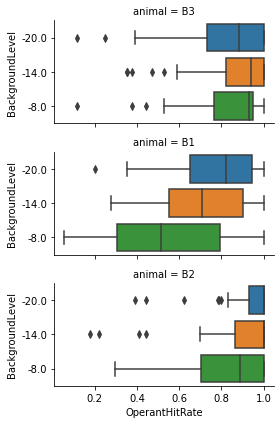

In [36]:
sns.catplot(data=operant_snr.sort_values(by='session_time'), 
             x='OperantHitRate', y='BackgroundLevel', row='animal',
#             hue= 'date', x='OperantHitRate', y='BackgroundLevel', row='animal',
             orient='h', kind='box', aspect=2, height=2)
plt.savefig('OperantHitRate.pdf', transparent=True)

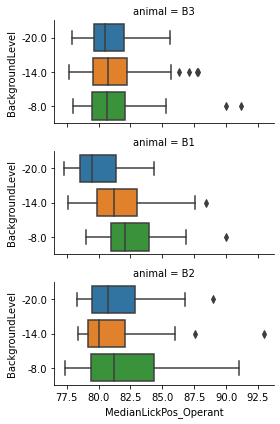

In [37]:
sns.catplot(data=operant_snr.sort_values(by='session_time'), 
             x='MedianLickPos_Operant', y='BackgroundLevel', row='animal',
#              y= 'date', x='MedianLickPos_Operant', hue='BackgroundLevel', row='animal',
             orient='h', kind='box', aspect=2, height=2)
plt.savefig('MedianLickPos_Operant.pdf', transparent=True)

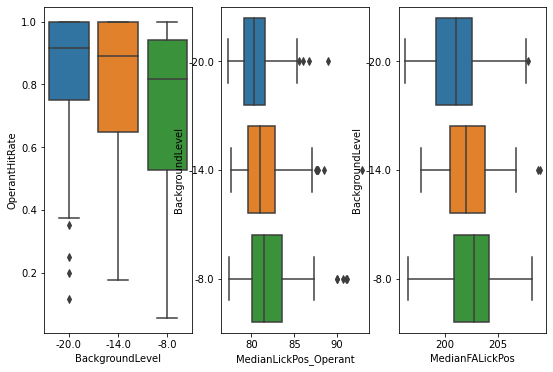

In [38]:
fig, ax = plt.subplots(1,3, figsize=(9,6))
sns.boxplot(data=operant_snr.sort_values(by='session_time'),
            y='OperantHitRate', x='BackgroundLevel', ax=ax[0],)
sns.boxplot(data=operant_snr.sort_values(by='session_time'), 
             x='MedianLickPos_Operant', y='BackgroundLevel', orient='h', ax=ax[1])
sns.boxplot(data=operant_snr.sort_values(by='session_time'), 
             x='MedianFALickPos', y='BackgroundLevel', orient='h', ax=ax[2])

plt.savefig('VaryingSNR.pdf', transparent=True)

In [39]:
for a in operant_snr.groupby('BackgroundLevel')['OperantHitRate'].apply(list).values:
    print(np.median(a))

0.9166666666666666
0.8888888888888888
0.8165266106442577


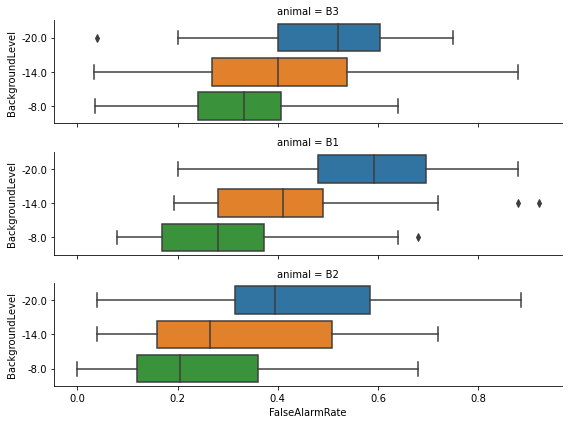

In [40]:
sns.catplot(data=operant_snr.sort_values(by='session_time'), 
#              y= 'date', x='FalseAlarmRate', hue='BackgroundLevel', row='animal',
             x='FalseAlarmRate', y='BackgroundLevel', row='animal',
             orient='h', kind='box', aspect=4, height=2)

In [42]:

def plot_lick_performance(ax, df, binsize=1, sigma = 20, zone_size=None, field='LickHist', label=None, 
                         plot_what='Anticipatory', metric='Total Licks', suppress_dates=False, minimal=False):
    hist = []
    ntrials = []
    antic = []
    antic_a = []
    antic_b2 = []
    antic_c = []
    in_a = []
    in_b1 = []
    in_b2 = []
    in_c = []
    
    rwd_pos = []
    rewarded = []
    for index, row in df.sort_values(by='session_time').iterrows():
        h = row[field]
        rp = row['RewardPosition']

#         hist.append(h)
        ntrials.append(h.shape[0])
        zone_len = row['TrackLength']/8
        reward = row['RewardZone']
        
        rwd_pos.append(rp - reward)
        rewarded.append(scipy.ndimage.gaussian_filter1d((~np.isnan(rp)).astype('float'),sigma))

        x = np.arange(0, row['TrackLength'], binsize)
        
        if not zone_size:
            zone_size = zone_len
        elif zone_size=='half':
            zone_size = zone_len/2
            
        pre_rwd_idx = (x > reward-zone_size) & (x < reward)
        rwd_idx = (x > reward) & (x < reward + zone_size)
        pre_rwd_idx_a = (x > reward-zone_size - zone_len*2) & (x < reward - zone_len*2)
        rwd_idx_a = (x > reward  - zone_len*2) & (x < reward + zone_size - zone_len*2)
        pre_rwd_idx_b2 = (x > reward-zone_size + zone_len*4) & (x < reward + zone_len*4)
        rwd_idx_b2 = (x > reward + zone_len*4) & (x < reward + zone_size + zone_len*4)
        pre_rwd_idx_c = (x > reward-zone_size + zone_len*2) & (x < reward + zone_len*2)
        rwd_idx_c = (x > reward + zone_len*2) & (x < reward + zone_size + zone_len*2)
        
        if metric == 'Total Licks':
            antic.append(scipy.ndimage.gaussian_filter1d((np.sum(h[:,pre_rwd_idx], axis=1)).astype('float'),sigma))
            antic_b2.append(scipy.ndimage.gaussian_filter1d((np.sum(h[:,pre_rwd_idx_b2], axis=1)).astype('float'),sigma))
            antic_a.append(scipy.ndimage.gaussian_filter1d((np.sum(h[:,pre_rwd_idx_a], axis=1)).astype('float'),sigma))
            antic_c.append(scipy.ndimage.gaussian_filter1d((np.sum(h[:,pre_rwd_idx_c], axis=1)).astype('float'),sigma))

            in_a.append(scipy.ndimage.gaussian_filter1d((np.sum(h[:,rwd_idx_a], axis=1)).astype('float'),sigma))
            in_b1.append(scipy.ndimage.gaussian_filter1d((np.sum(h[:,rwd_idx], axis=1)).astype('float'),sigma))
            in_b2.append(scipy.ndimage.gaussian_filter1d((np.sum(h[:,rwd_idx_b2], axis=1)).astype('float'),sigma))
            in_c.append(scipy.ndimage.gaussian_filter1d((np.sum(h[:,rwd_idx_c], axis=1)).astype('float'),sigma))
        elif metric == 'Lick Prob':
            antic.append(scipy.ndimage.gaussian_filter1d((np.sum(h[:,pre_rwd_idx], axis=1) > 0).astype('float'),sigma))
            antic_b2.append(scipy.ndimage.gaussian_filter1d((np.sum(h[:,pre_rwd_idx_b2], axis=1) > 0).astype('float'),sigma))
            antic_a.append(scipy.ndimage.gaussian_filter1d((np.sum(h[:,pre_rwd_idx_a], axis=1) > 0).astype('float'),sigma))
            antic_c.append(scipy.ndimage.gaussian_filter1d((np.sum(h[:,pre_rwd_idx_c], axis=1) > 0).astype('float'),sigma))

            in_a.append(scipy.ndimage.gaussian_filter1d((np.sum(h[:,rwd_idx_a], axis=1) > 0).astype('float'),sigma))
            in_b1.append(scipy.ndimage.gaussian_filter1d((np.sum(h[:,rwd_idx], axis=1) > 0).astype('float'),sigma))
            in_b2.append(scipy.ndimage.gaussian_filter1d((np.sum(h[:,rwd_idx_b2], axis=1) > 0).astype('float'),sigma))
            in_c.append(scipy.ndimage.gaussian_filter1d((np.sum(h[:,rwd_idx_c], axis=1) > 0).astype('float'),sigma))

    
#     allh = np.vstack(hist)
    
    all_antic = np.hstack(antic)
    all_antic_b2 = np.hstack(antic_b2)
    all_antic_a = np.hstack(antic_a)
    all_antic_c = np.hstack(antic_c)

    all_in_b1 = np.hstack(in_b1)
    all_in_b2 = np.hstack(in_b2)
    all_in_a = np.hstack(in_a)
    all_in_c = np.hstack(in_c)
   
    all_ntrials = np.hstack(ntrials)
    
    if plot_what == 'Anticipatory':
        ax.plot( all_antic, 
                 label='Anticipatory Lickrate')
        ax.plot( all_antic_a, 
                 label='Equivalent A')
        ax.plot( all_antic_b2, 
                 label='Equivalent B2')
        ax.plot( all_antic_c, 
                 label='Equivalent C')
    elif plot_what == 'In Zone':
        ax.plot( all_in_b1, 
             label='In Zone Lickrate')
        ax.plot( all_in_a, 
                 label='Equivalent A')
        ax.plot( all_in_b2, 
                 label='Equivalent B2')
        ax.plot( all_in_c, 
                 label='Equivalent C')
    elif plot_what == 'Performance':
        ax.plot( (all_antic-all_antic_b2)/(all_antic+all_antic_b2), 
                 label='Anticipatory Performance (vs B2)')
        if not minimal:
            ax.plot( (all_antic-all_antic_a)/(all_antic+all_antic_a), 
                     label='Anticipatory Performance (vs A)')
            ax.plot( (all_antic-all_antic_c)/(all_antic+all_antic_c), 
                     label='Anticipatory Performance (vs C)')
    elif plot_what == 'In Zone Ratio':
        ax.plot( (all_in_b1-all_in_c)/(all_in_b1+all_in_c), 
                 label='In Zone (vs C)')
        if not minimal:
            ax.plot( (all_in_b1-all_in_a)/(all_in_b1+all_in_a), 
                     label='In Zone (vs A)')
            ax.plot( (all_in_b1-all_in_b2)/(all_in_b1+all_in_b2), 
                     label='In Zone (vs B2)')
    elif plot_what == 'False Alarm Ratio':
        ax.plot( (all_antic - all_in_b2)/(all_in_b2+all_antic), 
                 label='False Alarm')
    elif plot_what == 'Reward Position':
        ax.plot( np.hstack(rwd_pos), 
                 label='Relative Reward Position')
    elif plot_what == 'Reward Prob':
        ax.plot( np.hstack(rewarded), 
                 label='Reward Prob')

    
#     ax.plot( (all_antic-all_antic_b2)/(all_antic+all_antic_b2), 
#              label='Anticipatory Performance')
#     ax.plot( (all_in_b1-all_in_b2)/(all_in_b1+all_in_b2), 
#              label='In-Zone Performance')

    
    dates = df.sort_values(by='session_time').date.values
    track_lengths = df.sort_values(by='session_time').TrackLength.values
    snr = df.sort_values(by='session_time').BackgroundLevel.values
    dateticks = []
    datelabels = []
    last_b = 0
    for i, b in enumerate(np.cumsum(all_ntrials)):
        if i < len(dates)-1:
            if (dates[i] == dates[i+1]) & (snr[i] == snr[i+1]):
                continue
        ax.axvline(b, color=[0.15, 0.15, 0.15])
        dateticks.append((b+last_b)/2)
        if (snr[i] == -20.0):
            datelabels.append('{}({})'.format(dates[i], track_lengths[i]))
        else:
            datelabels.append('{}({})'.format(dates[i], snr[i]))
        last_b = b
                
    if not suppress_dates:
        ax.set_title('Animal {}'.format(df.iloc[0].animal), pad=50)
        axtop = ax.secondary_xaxis('top')
        axtop.set_xticks(dateticks)
        axtop.set_xticklabels(datelabels, rotation=90)


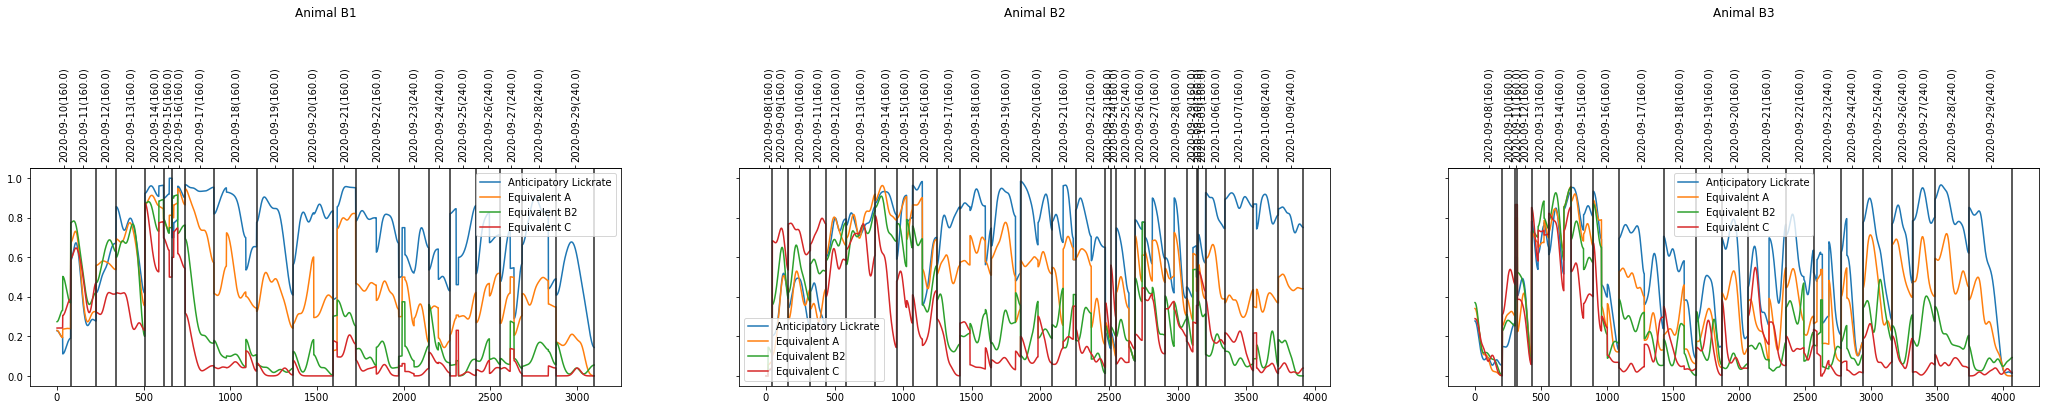

In [44]:
fig, ax = plt.subplots(1,3, figsize=(36,4), sharey=True)
df2 = df.query("(RewardType=='Classical') & TotalLaps > 7 ")
plot_lick_performance(ax[0], df2.query('animal=="B1"'), zone_size=10, metric='Lick Prob');
plot_lick_performance(ax[1], df2.query('animal=="B2"'), zone_size=10, metric='Lick Prob');
plot_lick_performance(ax[2], df2.query('animal=="B3"'), zone_size=10, metric='Lick Prob');
ax[0].legend()
ax[1].legend()
ax[2].legend()
# fig.suptitle("Comparing Anticipatory and In-Zone Licking in B1 and B2 During Classical Training Phase", 
#              fontsize=14, y=1.2)

<ipython-input-42-f67a09ebcf59>:99: RuntimeWarning: invalid value encountered in true_divide
  ax.plot( (all_antic-all_antic_b2)/(all_antic+all_antic_b2),
<ipython-input-42-f67a09ebcf59>:102: RuntimeWarning: invalid value encountered in true_divide
  ax.plot( (all_antic-all_antic_a)/(all_antic+all_antic_a),
<ipython-input-42-f67a09ebcf59>:104: RuntimeWarning: invalid value encountered in true_divide
  ax.plot( (all_antic-all_antic_c)/(all_antic+all_antic_c),


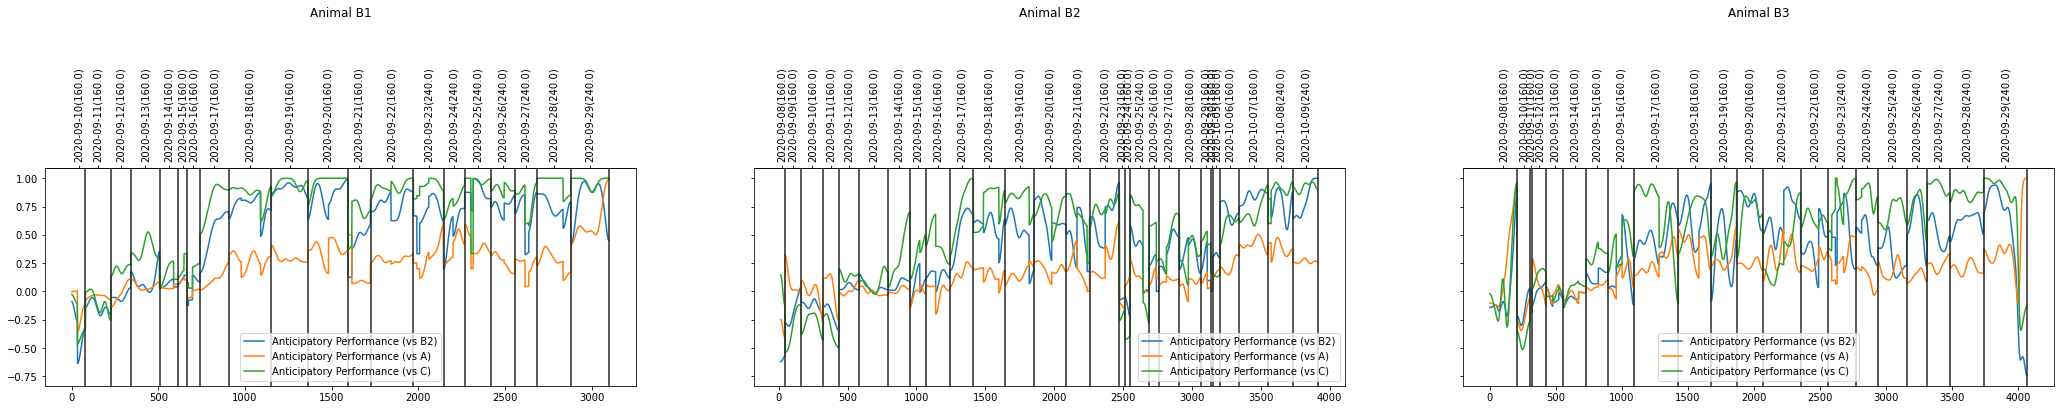

In [46]:
fig, ax = plt.subplots(1,3, figsize=(36,4), sharey=True)
df2 = df.query("(RewardType=='Classical') & TotalLaps > 7 ")
plot_lick_performance(ax[0], df2.query('animal=="B1"'), zone_size=10, plot_what='Performance', metric='Lick Prob');
plot_lick_performance(ax[1], df2.query('animal=="B2"'), zone_size=10, plot_what='Performance', metric='Lick Prob');
plot_lick_performance(ax[2], df2.query('animal=="B3"'), zone_size=10, plot_what='Performance', metric='Lick Prob');
ax[0].legend()
ax[1].legend()
ax[2].legend()
# fig.suptitle("Comparing Anticipatory and In-Zone Licking in B1 and B2 During Classical Training Phase", 
#              fontsize=14, y=1.2)

<ipython-input-42-f67a09ebcf59>:99: RuntimeWarning: invalid value encountered in true_divide
  ax.plot( (all_antic-all_antic_b2)/(all_antic+all_antic_b2),
<ipython-input-42-f67a09ebcf59>:102: RuntimeWarning: invalid value encountered in true_divide
  ax.plot( (all_antic-all_antic_a)/(all_antic+all_antic_a),
<ipython-input-42-f67a09ebcf59>:104: RuntimeWarning: invalid value encountered in true_divide
  ax.plot( (all_antic-all_antic_c)/(all_antic+all_antic_c),
<ipython-input-42-f67a09ebcf59>:99: RuntimeWarning: invalid value encountered in true_divide
  ax.plot( (all_antic-all_antic_b2)/(all_antic+all_antic_b2),
<ipython-input-42-f67a09ebcf59>:102: RuntimeWarning: invalid value encountered in true_divide
  ax.plot( (all_antic-all_antic_a)/(all_antic+all_antic_a),
<ipython-input-42-f67a09ebcf59>:104: RuntimeWarning: invalid value encountered in true_divide
  ax.plot( (all_antic-all_antic_c)/(all_antic+all_antic_c),


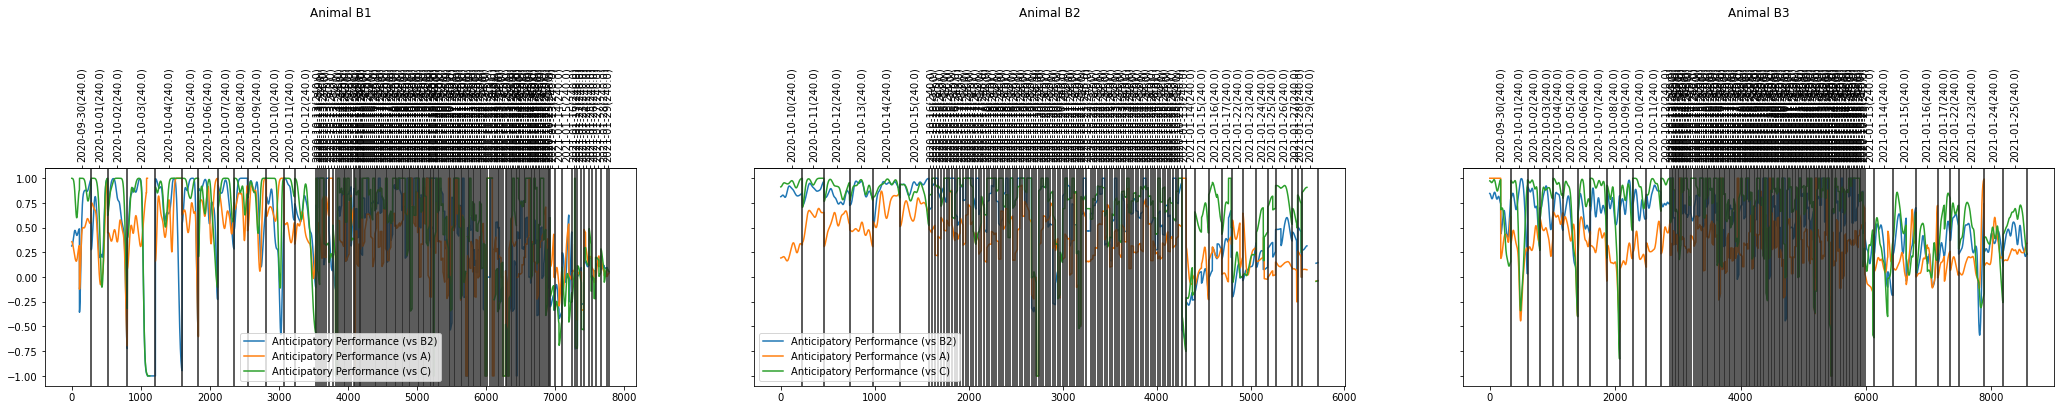

In [47]:
fig, ax = plt.subplots(1,3, figsize=(36,4), sharey=True)
df2 = df.query("(RewardType=='Operant') & TotalLaps > 7 ")
plot_lick_performance(ax[0], df2.query('animal=="B1"'), zone_size=10, plot_what='Performance', metric='Lick Prob');
plot_lick_performance(ax[1], df2.query('animal=="B2"'), zone_size=10, plot_what='Performance', metric='Lick Prob');
plot_lick_performance(ax[2], df2.query('animal=="B3"'), zone_size=10, plot_what='Performance', metric='Lick Prob');
ax[0].legend()
ax[1].legend()

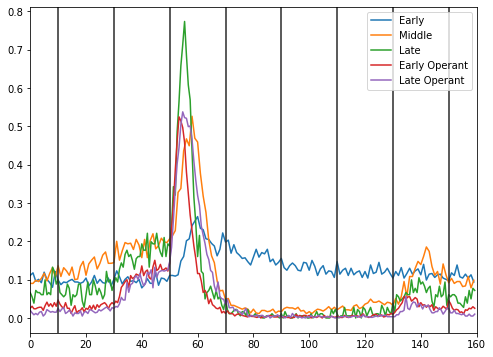

In [41]:
early = df.query("TotalLaps > 5"
                          "& ( date <= '2020-09-13' & (animal == 'B1' | animal == 'B3')"
                           "| ( date <= '2020-09-12' & (animal == 'B2')))")
middle = df.query("TotalLaps > 5"
                          "& date >= '2020-09-17' & date <= '2020-09-19'")

late = df.query("TotalLaps > 5"
                "& (TrackLength == 240)"
                "& ( date >= '2020-09-26' & date <= '2020-09-29' & (animal == 'B1' | animal == 'B3')"
                "| ( date >= '2020-10-09' & date <= '2020-10-09' & (animal == 'B2')))")

early_operant = df.query("TotalLaps > 5"
                         "& RewardType=='Operant' "
                "& ( date >= '2020-10-01' & date <= '2020-10-03' & (animal == 'B1' | animal == 'B3')"
                "| ( date >= '2020-10-11' & date <= '2020-10-13' & (animal == 'B2')))")

late_operant = df.query("TotalLaps > 5"
                         "& RewardType=='Operant' "
                "& ( date >= '2020-10-10' & date <= '2020-10-12' & (animal == 'B1' | animal == 'B3')"
                "| ( date >= '2020-10-14' & date <= '2020-10-15' & (animal == 'B2')))")

binsize=1

an = 'B2'

early_lick_hist = [row['LickHist'] for index, row in early.query("animal=='{}'".format(an)).sort_values(by='session_time').iterrows()]
early_h = np.vstack(early_lick_hist)

middle_lick_hist = [row['LickHist'] for index, row in middle.query("animal=='{}'".format(an)).sort_values(by='session_time').iterrows()]
middle_h = np.vstack(middle_lick_hist)

late_lick_hist = [row['LickHist'] for index, row in late.query("animal=='{}'".format(an)).sort_values(by='session_time').iterrows()]
late_h = np.vstack(late_lick_hist)

early_operant_lick_hist = [row['LickHist'] for index, row in early_operant.query("animal=='{}'".format(an)).sort_values(by='session_time').iterrows()]
early_o_h = np.vstack(early_operant_lick_hist)

late_operant_lick_hist = [row['LickHist'] for index, row in late_operant.query("animal=='{}'".format(an)).sort_values(by='session_time').iterrows()]
late_o_h = np.vstack(late_operant_lick_hist)


fig, ax = plt.subplots(1,1,figsize=(8,6))
ax.set_xlim(0,160)
ax.plot(np.arange(0,160,binsize), np.mean(early_h >0, axis=0), label='Early')
ax.plot(np.arange(0,160,binsize), np.mean(middle_h > 0, axis=0), label='Middle')
ax.plot(np.arange(0,240,binsize)*160/240, np.mean(late_h > 0, axis=0), label='Late')
ax.plot(np.arange(0,240,binsize)*160/240, np.mean(early_o_h > 0, axis=0), label='Early Operant')
ax.plot(np.arange(0,240,binsize)*160/240, np.mean(late_o_h > 0, axis=0), label='Late Operant')
lines = [10,30,50,70,90,110,130,150]
for l in lines:
    ax.axvline(l, color=[0.15, 0.15, 0.15])
ax.legend()


plt.savefig('LickProbability_B2.pdf', transparent=True)

<ipython-input-42-f67a09ebcf59>:99: RuntimeWarning: invalid value encountered in true_divide
  ax.plot( (all_antic-all_antic_b2)/(all_antic+all_antic_b2),
<ipython-input-42-f67a09ebcf59>:115: RuntimeWarning: invalid value encountered in true_divide
  ax.plot( (all_antic - all_in_b2)/(all_in_b2+all_antic),


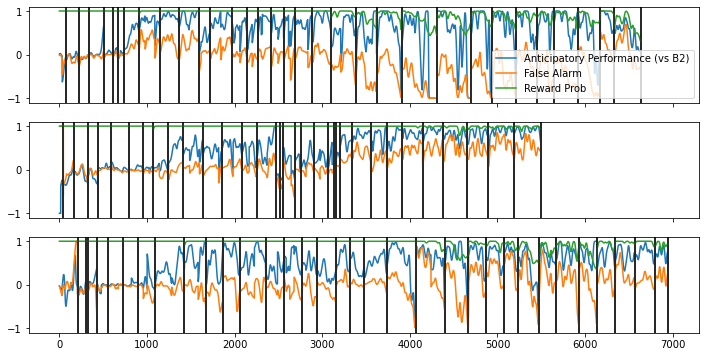

In [48]:
# Define the zone before the reward as our target zone. What is the performance over time?
fig, ax = plt.subplots(3,1, figsize=(12,6), sharey=True, sharex=True)
df2 = df.query("TotalLaps > 6"
              "& ( date <= '2020-10-12' & (animal == 'B1' | animal == 'B3')"
              "| ( date <= '2020-10-15' & (animal == 'B2')))")
plot_lick_performance(ax[0], df2.query('animal=="B1"'), sigma=10, plot_what='Performance', metric='Lick Prob', suppress_dates=True, minimal=True);
plot_lick_performance(ax[1], df2.query('animal=="B2"'), sigma=10, plot_what='Performance', metric='Lick Prob', suppress_dates=True, minimal=True);
plot_lick_performance(ax[2], df2.query('animal=="B3"'), sigma=10, plot_what='Performance', metric='Lick Prob', suppress_dates=True, minimal=True);
# fig.suptitle("Comparing Anticipatory and In-Zone Licking in B1 and B2 During Classical Training Phase", 
#         
plot_lick_performance(ax[0], df2.query('animal=="B1"'), sigma=10, plot_what='False Alarm Ratio', metric='Lick Prob', suppress_dates=True, minimal=True);
plot_lick_performance(ax[1], df2.query('animal=="B2"'), sigma=10, plot_what='False Alarm Ratio', metric='Lick Prob', suppress_dates=True, minimal=True);
plot_lick_performance(ax[2], df2.query('animal=="B3"'), sigma=10, plot_what='False Alarm Ratio', metric='Lick Prob', suppress_dates=True, minimal=True);

plot_lick_performance(ax[0], df2.query('animal=="B1"'), sigma=10, zone_size=5, plot_what='Reward Prob', suppress_dates=True, minimal=True);
plot_lick_performance(ax[1], df2.query('animal=="B2"'), sigma=10, zone_size=5, plot_what='Reward Prob', suppress_dates=True, minimal=True);
plot_lick_performance(ax[2], df2.query('animal=="B3"'), sigma=10, zone_size=5, plot_what='Reward Prob', suppress_dates=True, minimal=True);

ax[0].legend()
plt.savefig('AllAnimalsPerformanceMetrics.pdf', transparent=True)

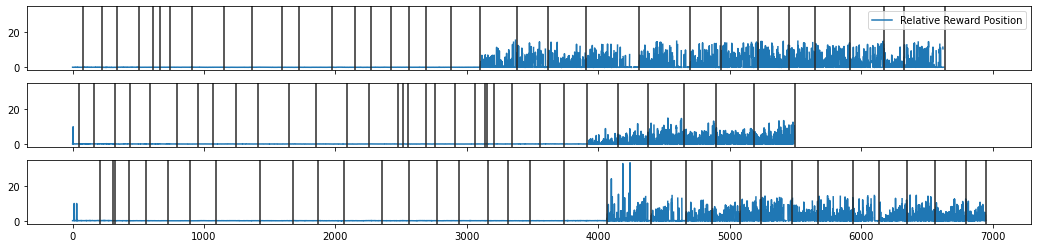

In [49]:
# Define the zone before the reward as our target zone. What is the performance over time?
fig, ax = plt.subplots(3,1, figsize=(18,4), sharey=True, sharex=True)
df2 = df.query("TotalLaps > 6"
              "& ( date <= '2020-10-12' & (animal == 'B1' | animal == 'B3')"
              "| ( date <= '2020-10-15' & (animal == 'B2')))")

plot_lick_performance(ax[0], df2.query('animal=="B1"'), sigma=10, zone_size=5, plot_what='Reward Position', suppress_dates=True, minimal=True);
plot_lick_performance(ax[1], df2.query('animal=="B2"'), sigma=10, zone_size=5, plot_what='Reward Position', suppress_dates=True, minimal=True);
plot_lick_performance(ax[2], df2.query('animal=="B3"'), sigma=10, zone_size=5, plot_what='Reward Position', suppress_dates=True, minimal=True);

ax[0].legend()

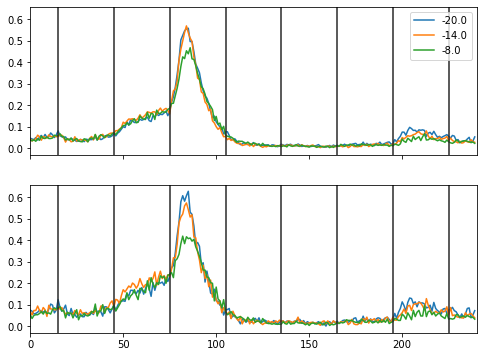

In [50]:

early_operant_snr = df.query("TotalLaps > 4"
                         "& RewardType=='Operant' "
                "& ( date >= '2020-10-13' & date <= '2020-10-25' & (animal == 'B1' | animal == 'B3')"
                "| ( date >= '2020-10-16' & date <= '2020-10-25' & (animal == 'B2')))")

late_operant_snr = df.query("TotalLaps > 4"
                         "& RewardType=='Operant' "
                "& ( date >= '2020-10-22' & date <= '2020-10-25' & (animal == 'B1' | animal == 'B3')"
                "| ( date >= '2020-10-22' & date <= '2020-10-25' & (animal == 'B2')))")

an = 'B2'

snr = [-20.0, -14.0, -8.0]
early_o_h = []
late_o_h = []
for s in snr:
    hist = [row['LickHist'] for index, row in early_operant_snr.query(
        "animal=='{}' & BackgroundLevel=={}".format(an,s)).sort_values(by='session_time').iterrows()]
    early_o_h.append(np.vstack(hist))
    hist = [row['LickHist'] for index, row in late_operant_snr.query(
        "animal=='{}' & BackgroundLevel=={}".format(an,s)).sort_values(by='session_time').iterrows()]
    late_o_h.append(np.vstack(hist))

    
fig, ax = plt.subplots(2,1,figsize=(8,6), sharex=True, sharey=True)
ax[0].set_xlim(0,240)
for idx, s in enumerate(snr):
    ax[0].plot(np.arange(0,240,binsize), np.mean(early_o_h[idx] > 0, axis=0), label='{}'.format(s))
    ax[1].plot(np.arange(0,240,binsize), np.mean(late_o_h[idx] > 0, axis=0), label='{}'.format(s))
lines = [15,45,75,105,135,165,195,225]
for l in lines:
    ax[0].axvline(l, color=[0.15, 0.15, 0.15])
    ax[1].axvline(l, color=[0.15, 0.15, 0.15])
ax[0].legend()


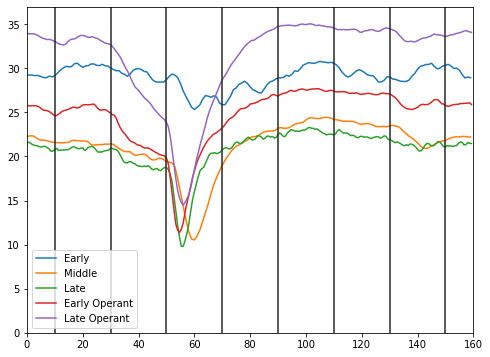

In [51]:
early = df.query("TotalLaps > 7"
                          "& ( date <= '2020-09-13' & (animal == 'B1' | animal == 'B3')"
                           "| ( date <= '2020-09-12' & (animal == 'B2')))")
middle = df.query("TotalLaps > 7"
                          "& date >= '2020-09-17' & date <= '2020-09-19'")

late = df.query("TotalLaps > 7"
                "& (TrackLength == 240)"
                "& ( date >= '2020-09-26' & date <= '2020-09-29' & (animal == 'B1' | animal == 'B3')"
                "| ( date >= '2020-10-09' & date <= '2020-10-09' & (animal == 'B2')))")

early_operant = df.query("TotalLaps > 7"
                         "& RewardType=='Operant' "
                "& ( date >= '2020-10-01' & date <= '2020-10-03' & (animal == 'B1' | animal == 'B3')"
                "| ( date >= '2020-10-11' & date <= '2020-10-13' & (animal == 'B2')))")

late_operant = df.query("TotalLaps > 7"
                         "& RewardType=='Operant' "
                "& ( date >= '2020-10-10' & date <= '2020-10-12' & (animal == 'B1' | animal == 'B3')"
                "| ( date >= '2020-10-14' & date <= '2020-10-15' & (animal == 'B2')))")

binsize=1

an = 'B2'

early_lick_hist = [row['SpeedHist'] for index, row in early.query("animal=='{}'".format(an)).sort_values(by='session_time').iterrows()]
early_h = np.vstack(early_lick_hist)

middle_lick_hist = [row['SpeedHist'] for index, row in middle.query("animal=='{}'".format(an)).sort_values(by='session_time').iterrows()]
middle_h = np.vstack(middle_lick_hist)

late_lick_hist = [row['SpeedHist'] for index, row in late.query("animal=='{}'".format(an)).sort_values(by='session_time').iterrows()]
late_h = np.vstack(late_lick_hist)

early_operant_lick_hist = [row['SpeedHist'] for index, row in early_operant.query("animal=='{}'".format(an)).sort_values(by='session_time').iterrows()]
early_o_h = np.vstack(early_operant_lick_hist)

late_operant_lick_hist = [row['SpeedHist'] for index, row in late_operant.query("animal=='{}'".format(an)).sort_values(by='session_time').iterrows()]
late_o_h = np.vstack(late_operant_lick_hist)


fig, ax = plt.subplots(1,1,figsize=(8,6))
ax.set_xlim(0,160)
ax.plot(np.arange(0,160,binsize), np.mean(early_h, axis=0)*500, label='Early')
ax.plot(np.arange(0,160,binsize), np.mean(middle_h, axis=0)*500, label='Middle')
ax.plot(np.arange(0,240,binsize)*160/240, np.mean(late_h, axis=0)*500, label='Late')
ax.plot(np.arange(0,240,binsize)*160/240, np.mean(early_o_h, axis=0)*500, label='Early Operant')
ax.plot(np.arange(0,240,binsize)*160/240, np.mean(late_o_h, axis=0)*500, label='Late Operant')
ax.set_ylim(0,37)
lines = [10,30,50,70,90,110,130,150]
for l in lines:
    ax.axvline(l, color=[0.15, 0.15, 0.15])
ax.legend()


plt.savefig('Speed_B2.pdf', transparent=True)